#### Install dependencies

In [1]:
# Install dependencies
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import statsmodels.api as sm
import os
import ast
import calendar
from textblob import TextBlob

#### Load data

In [2]:
# Load data

# Set the style for seaborn
sns.set(style="white")

# Get the absolute path to the directory containing the notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))  # Or hardcode if needed

# Construct the full path to the CSV file
csv_path = os.path.join(notebook_dir, 'allocine_films_cleaned.csv')

# Load the dataset
df = pd.read_csv(csv_path)

# Display full columns of the dataset
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
# Display the first few row of the dataset
# df.head()

#### Create new columns from date objects

In [3]:
# Convert to datetime
df['release_date'] = pd.to_datetime(df['release_date'], errors='coerce')

# Extract year
df['release_date_france_year'] = df['release_date'].dt.year
df['release_date_france_month'] = df['release_date'].dt.month
df['release_date_france_day'] = df['release_date'].dt.day

# Map 'release_date_france_month' to the month name
df['release_date_france_month'] = df['release_date_france_month'].map(lambda x: calendar.month_name[int(x)] if pd.notnull(x) else np.nan)

#### Drop columns not needed

In [4]:
# Drop release_date related columns
df.drop(columns=['release_date', 'budget'], axis=1, inplace=True)

#### Re-order columns

In [5]:
ordered_columns = [
    # Film Identity & URLs
    'film_id', 'film_title', 'film_url', 'film_image_url',

    # Release Information
    'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
    'release_season', 'release_season_binary',
    'broadcast_category', 'broadcast_category_binary',
    'release_date_binary',

    # Core Details
    'duration', 'duration_binary',
    'year_of_production', 'year_of_production_binary',

    # People Involved
    'director', 'director_binary',
    'producers_list', 'producers_count', 'producers_count_binary',
    'top_stars_list', 'top_stars_count', 'top_stars_count_binary',

    # Cultural & Language Attributes
    'languages_list', 'languages_count',
    'nationality_list', 'nationality_list_count', 'nationality_list_binary',

    # Genres & Classification
    'associated_genres_list', 'associated_genres_count',

    # Performance Metrics
    'fr_entries', 'fr_entry_week_iso_week',
    'us_entries', 'us_entry_week_iso_week',

    # Ratings & Feedback
    'press_rating', 'press_rating_binary',
    'viewer_rating', 'viewer_rating_binary',
    'viewer_notes', 'viewer_critiques',
    'press_critics_count_num',

    # Recognition & Awards
    'award_count', 'nomination_count',

    # Trailer & Marketing
    'trailer_views_num', 'trailer_views_num_binary',

    # Synopsis & Fun Facts
    'synopsis', 'synopsis_length', 'synopsis_binary',
    'filming_secrets_num',

    # Distribution
    'distributor', 'distributor_binary'
]

# Reorder the DataFrame
df = df[ordered_columns]

#### Categorize duration

In [6]:
def categorize_duration(duration):
    if duration < 70:
        return "short-film"
    elif 70 < duration < 160:
        return "normal-film"
    elif 160 < duration < 210:
        return "long-film"
    else:
        return "very long film"
    
df['duration_classified'] = df['duration'].apply(lambda x: categorize_duration(x))

#### Categorize synopsis

In [7]:
# Calculate synopsis sentiment
df['synopsis_sentiment'] = df['synopsis'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)

In [8]:
def categorize_synopsis_length(num):
    if num != np.nan:
        if num <= 200:
            return "not long"
        elif 200 < num < 700:
            return "normal"
        elif 700 < num < 1000:
            return "long"
        else:
            return "very long"
              
def categorize_synopsis_sentiment(num):
    if num != np.nan:
        if num <= -0.2:
            return "negative"
        elif -0.2 < num < 0.2:
            return "neutral"
        elif 0.2 < num < 0.5:
            return "positive"
        else:
            return "very positive"
        
df['synopsis_length_categorized'] = df['synopsis_length'].apply(lambda x: categorize_synopsis_length(x))
df['synopisis_sentiment_categorized'] = df['synopsis_sentiment'].apply(lambda x: categorize_synopsis_sentiment(x))

#### Categorize award and nomination

In [9]:
def categorize_award_and_nomination(num):
    if num != np.nan:
        if num == 0:
            return 0
        elif num > 0:
            return 1
        
df['award_categorized'] = df['award_count'].apply(lambda x: categorize_award_and_nomination(x))
df['nomination_categorized'] = df['nomination_count'].apply(lambda x: categorize_award_and_nomination(x))

#### Calculate F-statistic for categorical variables

In [10]:
# Set standard columns
f_stat_groups = ['release_date_france_month', 'release_date_france_year', 'year_of_production',
       'release_date_france_day', 'release_season', 'release_season_binary',
       'broadcast_category', 'broadcast_category_binary',
       'release_date_binary', 'duration_binary',
       'year_of_production_binary', 'director',
       'director_binary',  'producers_count_binary',  'top_stars_count_binary', 'nationality_list_binary',
       'press_rating_binary', 
       'viewer_rating_binary', 
       'trailer_views_num_binary', 
       'synopsis_binary',
       'distributor', 'distributor_binary', 'duration_classified',
       'synopsis_length_categorized',
       'synopisis_sentiment_categorized', 'award_categorized',
       'nomination_categorized',
]


# Set exploded list-like columns
list_columns = [
    'producers_list', 'top_stars_list', 'languages_list',
    'nationality_list', 'associated_genres_list' 
]

results = []

# Run ANOVA on standard columns
for col in f_stat_groups:
    grouped = df.groupby(col)['fr_entries']
    valid_groups = [group.fillna('unavailable') for name, group in grouped if len(group.fillna('unavailable')) >= 2]
    if len(valid_groups) >= 2:
        anova_result = stats.f_oneway(*valid_groups)
        results.append({'feature': col, 'F-statistic': anova_result.statistic, 'p-value': anova_result.pvalue})

# Run ANOVA on Exploded list columns
for col in list_columns:
    exploded_df = df.explode(col)
    grouped = exploded_df.groupby(col)['fr_entries']
    valid_groups = [group.fillna('unavailable') for name, group in grouped if len(group.fillna('unavailable')) >= 3]
    if len(valid_groups) >= 2:
        anova_result = stats.f_oneway(*valid_groups)
        results.append(
            {
                'feature': f'{col} (exploded)',
                'F-statistic': anova_result.statistic,
                'p-value': anova_result.pvalue,
            }
        )

# Combine results into a single DataFrame
fstat_df = pd.DataFrame(results).sort_values(by='F-statistic', ascending=False).reset_index(drop=True)

print(fstat_df)


                              feature  F-statistic        p-value
0              nomination_categorized  1247.434531  3.684023e-265
1                  distributor_binary  1157.611148  9.660979e-247
2                   award_categorized   904.338234  2.236724e-194
3            trailer_views_num_binary   637.078454  2.061442e-138
4           top_stars_list (exploded)   131.168101  3.045542e-180
5                viewer_rating_binary    59.260810   1.444669e-14
6                 press_rating_binary    58.572502   2.047602e-14
7                 duration_classified    49.318598   9.503350e-32
8                  broadcast_category    40.046362  5.200430e-312
9                     duration_binary    37.533523   9.152675e-10
10        synopsis_length_categorized    34.802468   2.000919e-22
11                    synopsis_binary    32.954503   9.570055e-09
12             top_stars_count_binary    25.404194   4.689433e-07
13                        distributor    21.461462   0.000000e+00
14        

#### Check for multicollinearity between numerical columns

In [11]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
from sklearn.impute import SimpleImputer

# Ensure no non-numeric columns and no missing values
X = df[[
        'film_id', 'duration', 'producers_count', 
        'top_stars_count','languages_count', 'nationality_list_count',
        'associated_genres_count', 'press_rating',  'viewer_rating',
        'viewer_notes', 'viewer_critiques','press_critics_count_num',
        'award_count', 'nomination_count','trailer_views_num', 
        'synopsis_length','filming_secrets_num', 
        'synopsis_sentiment',]
        ]

# imputer = SimpleImputer(strategy='median')
# X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Add a constant for statsmodels compatibility
X_const = add_constant(X)

# Calculate VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_const.values, i+1) for i in range(len(X.columns))]

# Display VIFs sorted from highest to lowest
print(vif_data.sort_values(by="VIF", ascending=False))

                    Feature       VIF
10         viewer_critiques  3.357650
9              viewer_notes  2.717902
8             viewer_rating  2.677117
7              press_rating  2.670804
13         nomination_count  2.147219
12              award_count  1.863519
16      filming_secrets_num  1.713164
1                  duration  1.168860
5    nationality_list_count  1.098710
11  press_critics_count_num  1.095957
4           languages_count  1.077151
14        trailer_views_num  1.070291
6   associated_genres_count  1.066837
2           producers_count  1.063603
3           top_stars_count  1.063067
15          synopsis_length  1.044224
0                   film_id  1.028658
17       synopsis_sentiment  1.002487


#### Calculate mutual info regression on numerical columns

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import StandardScaler

# Define your feature set and target
X = df[['film_id', 'duration', 'producers_count',
        'top_stars_count','languages_count', 'nationality_list_count',
        'associated_genres_count', 'press_rating',  'viewer_rating',
        'viewer_notes', 'viewer_critiques','press_critics_count_num',
        'award_count', 'nomination_count','trailer_views_num', 
        'synopsis_length','filming_secrets_num', 
        'synopsis_sentiment',]]

y = df.loc[X.index, 'fr_entries']

# Standard scaling for each column
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Calculate Mutual Information
mi = mutual_info_regression(X_scaled, y)

# Create a DataFrame with sorted MI values
mi_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information': mi})
mi_df['Mutual Information'] = mi_df['Mutual Information'].round(2)
mi_df = mi_df.sort_values(by='Mutual Information', ascending=False)

# Display the result
print(mi_df)

                    Feature  Mutual Information
10         viewer_critiques                0.50
9              viewer_notes                0.48
16      filming_secrets_num                0.43
11  press_critics_count_num                0.26
14        trailer_views_num                0.17
13         nomination_count                0.10
1                  duration                0.06
0                   film_id                0.06
8             viewer_rating                0.06
7              press_rating                0.06
12              award_count                0.05
2           producers_count                0.03
6   associated_genres_count                0.03
5    nationality_list_count                0.03
15          synopsis_length                0.02
4           languages_count                0.01
3           top_stars_count                0.01
17       synopsis_sentiment                0.01


#### Calculate correlation coefficients on numerical columns

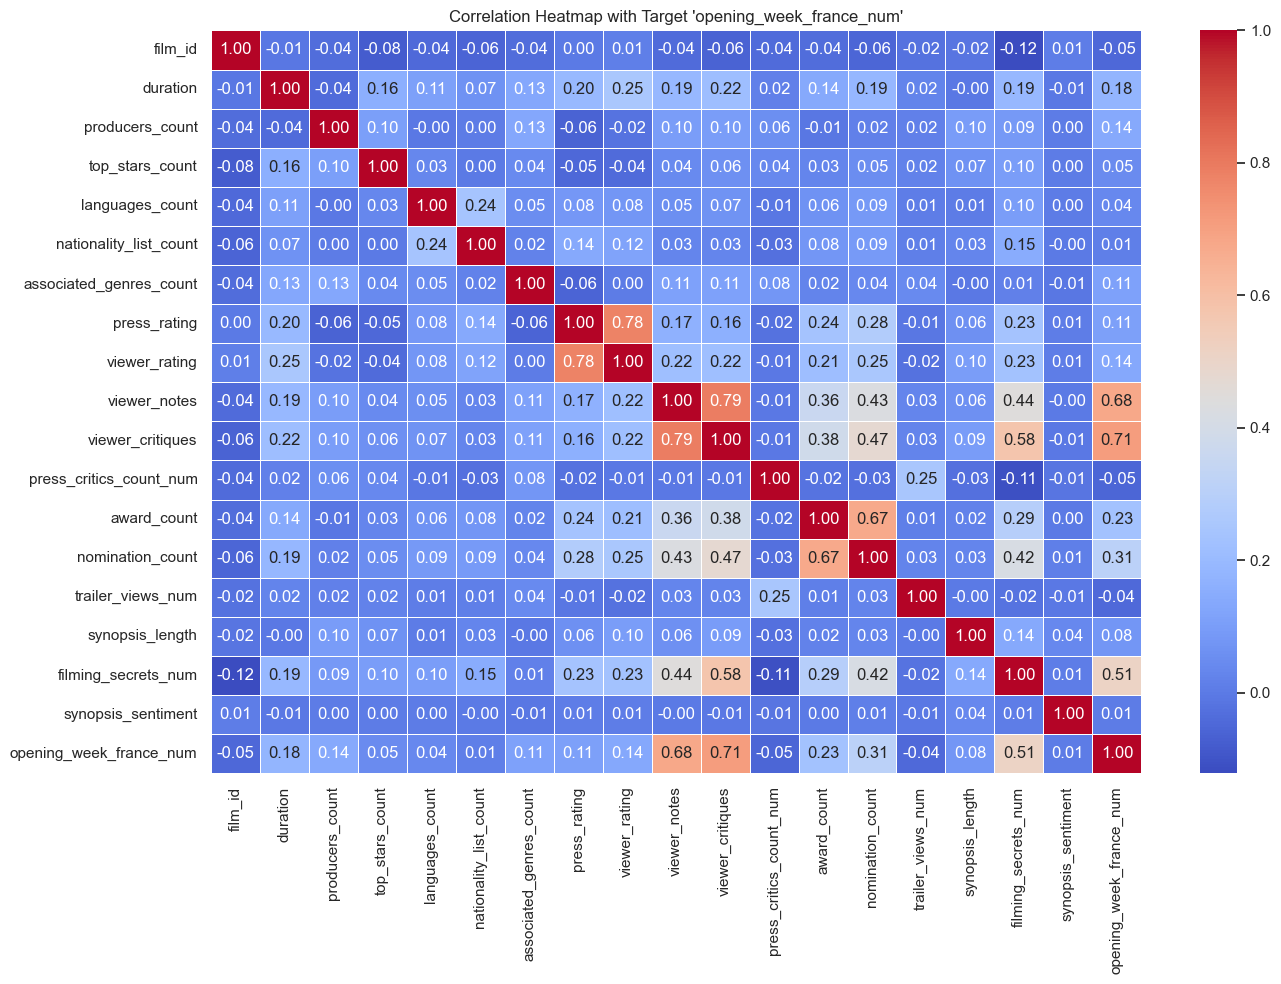

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

# Define features and target
X = df[['film_id', 'duration', 'producers_count',
        'top_stars_count','languages_count', 'nationality_list_count',
        'associated_genres_count', 'press_rating',  'viewer_rating',
        'viewer_notes', 'viewer_critiques','press_critics_count_num',
        'award_count', 'nomination_count','trailer_views_num', 
        'synopsis_length','filming_secrets_num', 
        'synopsis_sentiment',]]

y = df['fr_entries']


# Standard scaling
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Add the target back to the scaled DataFrame (not scaled, but imputed)
df_corr = X_scaled.copy()
df_corr['opening_week_france_num'] = y.reset_index(drop=True)

# Drop rows with NaN in the target before correlation
df_corr = df_corr.dropna(subset=['opening_week_france_num'])

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(df_corr.corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title("Correlation Heatmap with Target 'opening_week_france_num'")
plt.tight_layout()
plt.show()

#### Compare MIR and correlation results to choose numerical predictors

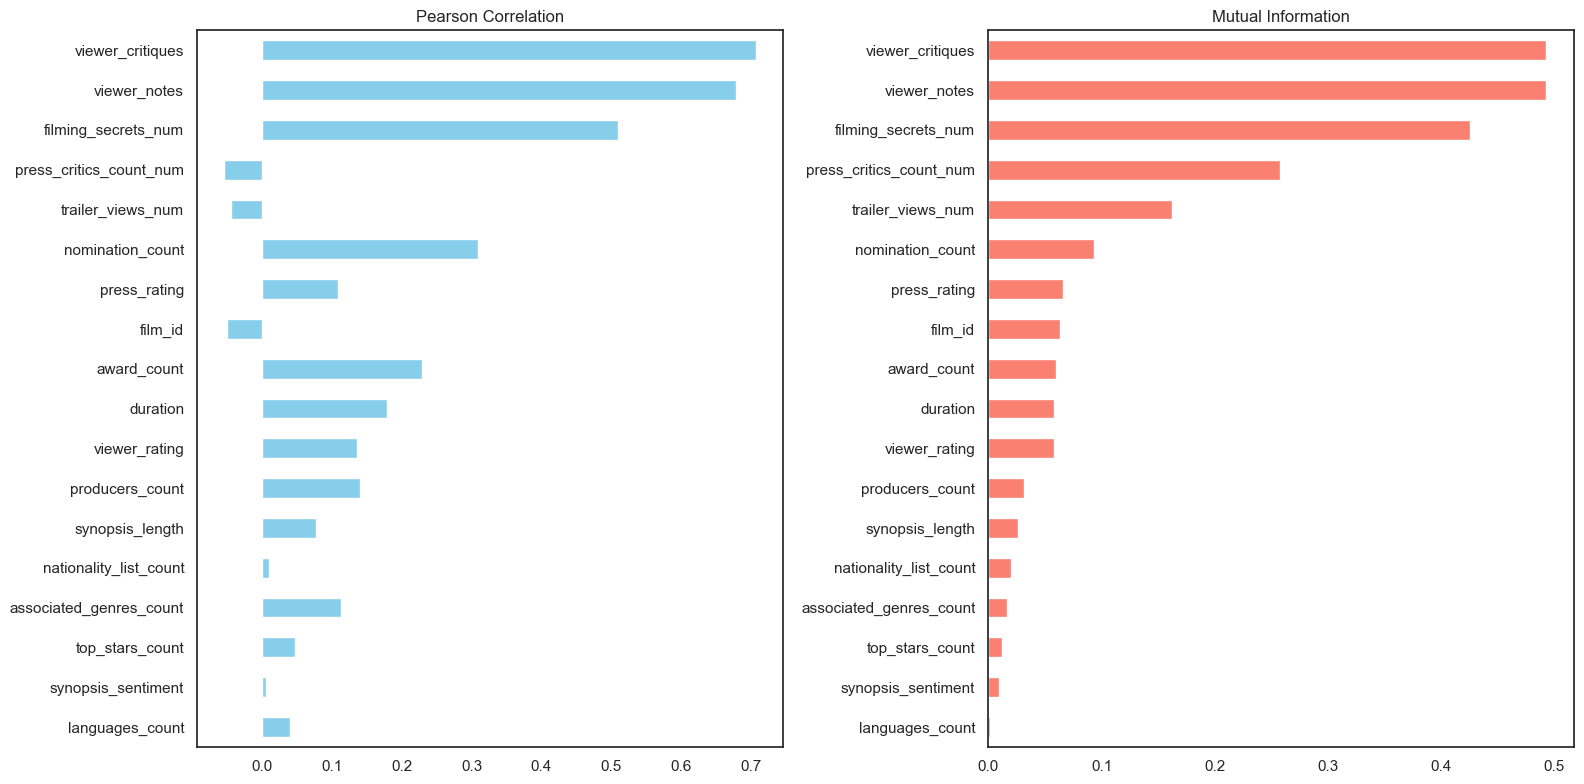

In [14]:
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate Pearson correlation with the target
correlations = df_corr.corr()['opening_week_france_num'].drop('opening_week_france_num')

# Calculate Mutual Information with the target
mi = mutual_info_regression(X_scaled, y.loc[X_scaled.index])
mi_series = pd.Series(mi, index=X_scaled.columns)

# Combine into a DataFrame
comparison_df = pd.DataFrame({
    'Pearson Correlation': correlations,
    'Mutual Information': mi_series
}).sort_values('Mutual Information', ascending=True)

# Plot side-by-side
fig, axes = plt.subplots(1, 2, figsize=(16, 8))
comparison_df['Pearson Correlation'].plot.barh(ax=axes[0], color='skyblue', title='Pearson Correlation')
comparison_df['Mutual Information'].plot.barh(ax=axes[1], color='salmon', title='Mutual Information')
plt.tight_layout()
plt.show()


#### Select initial features for model training

In [11]:
df_model = df[[
    # ===== Numerical Features =====
    'duration', 'year_of_production', 'producers_count', 'top_stars_count',
    'languages_count', 'nationality_list_count', 'associated_genres_count',
    'fr_entries', 'award_count', 'nomination_count',
    'trailer_views_num', 'synopsis_length', 'filming_secrets_num',

    # ===== Categorical/Binary Features =====
    'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
    'release_season', 'release_season_binary',
    'broadcast_category', 'broadcast_category_binary',
    'release_date_binary', 'duration_binary',
    'year_of_production_binary', 'director_binary',
    'producers_count_binary', 'top_stars_count_binary',
    'nationality_list_binary', 'press_rating_binary',
    'viewer_rating_binary', 'trailer_views_num_binary',
    'synopsis_binary', 'distributor_binary',
    'duration_classified', 'synopsis_sentiment',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'award_categorized', 'nomination_categorized',

    # ===== List-based / Text Features =====
    'film_id', 'film_title', 'director', 'distributor',
    'producers_list', 'top_stars_list', 'languages_list',
    'nationality_list', 'associated_genres_list',
    'synopsis',
]].copy()

#### Process film_title

In [12]:
# Create film length column
df_model['film_title_length'] = df_model['film_title'].apply(lambda x: len(x.replace(" ", "")) if isinstance(x, str) else 0)

# Drop the original columns 'film_title' if desired
# df_model.drop(['film_title', 'synopsis'], axis=1, inplace=True)

# Drop the original columns 'film_title' if desired
df_model.drop(['synopsis'], axis=1, inplace=True)

#### Standard scale numerical features

In [13]:
from sklearn.preprocessing import StandardScaler

# Define continuous columns to scale
continuous_cols = ['film_id', 'duration', 'producers_count', 'top_stars_count',
    'languages_count', 'nationality_list_count', 'associated_genres_count',
    'award_count', 'nomination_count', 'synopsis_sentiment', 
    'trailer_views_num', 'synopsis_length', 'filming_secrets_num', 'film_title_length',
]

# Apply standard scaling to continuous columns
scaler = StandardScaler()
df_model[continuous_cols] = scaler.fit_transform(df_model[continuous_cols])

#### Explode stringified lists and drop columns

In [14]:
def parse_stringified_lists(df, columns):
    for col in columns:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) and x.startswith('[') else x)
    return df

def encode_top_entities(df, threshold_dict):
    def encode(df, col, prefix, threshold):
        exploded = df[[col, 'fr_entries']].explode(col)
        totals = exploded.groupby(col)['fr_entries'].sum()
        top_items = totals[totals > threshold].index.tolist()

        # Efficient encoding using dictionary + pd.concat
        new_cols = {
            f'{prefix}_{item}': df[col].apply(lambda x: int(item in x))
            for item in top_items
        }

        df = pd.concat([df, pd.DataFrame(new_cols)], axis=1)
        return df

    df = encode(df, 'languages_list', 'lang', threshold_dict['languages'])
    df = encode(df, 'nationality_list', 'nat', threshold_dict['nationality'])
    df = encode(df, 'top_stars_list', 'star', threshold_dict['top_stars'])
    df = encode(df, 'producers_list', 'prod', threshold_dict['producers'])
    df = encode(df, 'associated_genres_list', 'genre', threshold_dict['genres'])

    # Drop original list columns
    df.drop([
        'languages_list',
        'nationality_list',
        'top_stars_list',
        'producers_list',
        'associated_genres_list'
    ], axis=1, inplace=True)
    
    return df

# Define which columns to parse
list_columns = [
    'top_stars_list',
    'associated_genres_list',
    'languages_list',
    'nationality_list',
    'producers_list'
]

# Parse stringified list columns
df_model = parse_stringified_lists(df_model, list_columns)

# Define thresholds per feature type
thresholds = {
    'languages': 5_000_000,
    'nationality': 10_000_000,
    'top_stars': 9_000_000,
    'producers': 7_000_000,
    'genres': 700_000_000
}

# Run the encoding pipeline
df_model_final = encode_top_entities(df_model, thresholds)

#### Convert categories to category dtypes

In [15]:
df_model_final_main = df_model_final.copy()

categorical_cols = [ 
    'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
    'release_season', 'release_season_binary', 'distributor',
    'broadcast_category', 'broadcast_category_binary',
    'release_date_binary', 'duration_binary',
    'year_of_production_binary', 'director_binary',
    'producers_count_binary', 'top_stars_count_binary',
    'nationality_list_binary', 'press_rating_binary',
    'viewer_rating_binary', 'trailer_views_num_binary',
    'synopsis_binary', 'distributor_binary', 
    'duration_classified', 'synopsis_sentiment', 'year_of_production',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'award_categorized', 'nomination_categorized', 'director',
]

# Convert all object-type columns in the list to category dtype
df_model_final_main[categorical_cols] = df_model_final_main[categorical_cols].apply(lambda x: x.astype(str).astype('category'))

#### Create copies of dataframe for model training

In [16]:
df_model_final_xgb = df_model_final_main.copy()
df_model_final_cat = df_model_final_main.copy()

#### Train and test XGBoost model

In [ ]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

X = df_model_final_xgb.drop('fr_entries', axis=1)
y = df_model_final_xgb['fr_entries']

X["stratify_combo"] = X["top_stars_count_binary"].astype(str) + "_" + X["trailer_views_num_binary"].astype(str)
X["stratify_combo"] = X["stratify_combo"].astype("category")

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X.drop(columns=['stratify_combo'], axis=1), y, test_size=0.2, random_state=42, stratify=X["stratify_combo"])

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Convert object columns to categorical
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')


# Initialize the XGBoost model
xgb_model_all = xgb.XGBRegressor(
    objective='reg:squarederror',  # Using MSE as the loss function for regression
    eval_metric='rmse',            # Adding RMSE as the evaluation metric
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.3,
    alpha=10,
    random_state=42,
    enable_categorical=True
)

# Train the model on the training data
xgb_model_all.fit(X_train, y_train, verbose=True)

# Make predictions on the test set
y_pred = xgb_model_all.predict(X_test)

# Calculate RMSE
mae_xgb_all = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae_xgb_all:.2f}")

# Calculate RMSE
rmse_xgb_all = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse_xgb_all:.2f}")

print("Training terminated CSV successfully!")

#### Get Top 20 Features based on XGBoost Model

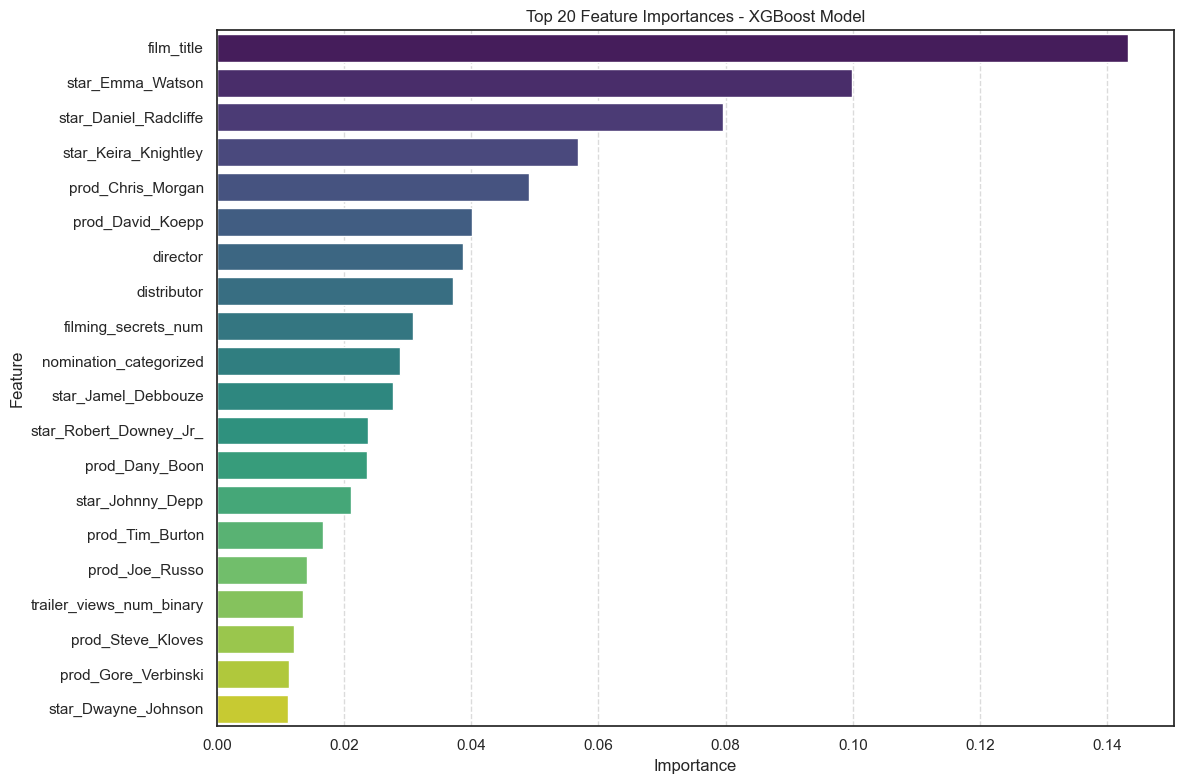

In [18]:
# Get Top 20 feature importances from the XGBoost model
feature_importances = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': xgb_model_all.feature_importances_
})

# Sort and select top 20
top_20 = feature_importances.sort_values(by='Importance', ascending=False).head(20)

# Plotting
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=top_20, palette='viridis', hue='Feature')
plt.title('Top 20 Feature Importances - XGBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


#### XGBoost Model based on Top 20 Features

In [ ]:
# Get Top 10 feature importances from the XGBoost model
X_top_20_xgb = df_model_final_xgb[['prod_Steve Kloves', 'star_Emma Watson', 'star_Daniel Radcliffe', 'nomination_categorized', 
                                   'prod_Terry Rossio', 'star_Robert Downey Jr.', 'prod_Chris Morgan', 'director', 
                                   'prod_Sam Raimi', 'star_Christian Clavier', 'prod_J.J. Abrams', 'star_Keira Knightley', 
                                   'star_Gérard Depardieu', 'prod_Melissa Rosenberg', 'star_Rupert Grint', 'prod_Dany Boon', 
                                   'prod_Joe Russo', 'distributor', 'star_Dany Boon', 'nat_Espagne',
                                   'trailer_views_num_binary', 'top_stars_count_binary']]

y_top_20_xgb = df_model_final_xgb['fr_entries']

X_top_20_xgb["stratify_combo"] = X_top_20_xgb['top_stars_count_binary'].astype(str) + "_" + X['trailer_views_num_binary'].astype(str)
X_top_20_xgb["stratify_combo"] = X_top_20_xgb['stratify_combo'].astype("category")

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_top_20_xgb.drop(columns=['top_stars_count_binary', 'trailer_views_num_binary', 'stratify_combo'], axis=1), y_top_20_xgb, test_size=0.2, random_state=42, stratify=X["stratify_combo"])

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Initialize the XGBoost model
xgb_model_top_20 = xgb.XGBRegressor(
    objective='reg:squarederror',  # Using MSE as the loss function for regression
    eval_metric='rmse',            # Adding RMSE as the evaluation metric
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.3,
    alpha=10,
    random_state=42,
    enable_categorical=True
)

# Train the model on the training data
xgb_model_top_20.fit(X_train, y_train, verbose=True)

# Make predictions on the test set
y_pred = xgb_model_top_20.predict(X_test)

# Calculate RMSE
mae_xgb_top_20 = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae_xgb_top_20:.2f}")

# Calculate RMSE
rmse_xgb_top_20 = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse_xgb_top_20:.2f}")

print("Training terminated CSV successfully!")

#### XGBoost Model based on Top 10 Features

In [ ]:
# Get Top 10 feature importances from the XGBoost model
X_top_10_xgb = df_model_final_xgb[['prod_Steve Kloves', 'star_Emma Watson', 'star_Daniel Radcliffe', 'nomination_categorized', 
                                   'prod_Terry Rossio', 'star_Robert Downey Jr.', 'prod_Chris Morgan', 'director', 
                                   'prod_Sam Raimi', 'star_Christian Clavier', 
                                   'trailer_views_num_binary', 'top_stars_count_binary']]

y_top_10_xgb = df_model_final_xgb['fr_entries']

X_top_10_xgb["stratify_combo"] = X_top_10_xgb['top_stars_count_binary'].astype(str) + "_" + X['trailer_views_num_binary'].astype(str)
X_top_10_xgb["stratify_combo"] = X_top_10_xgb['stratify_combo'].astype("category")

# Split the data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_top_20_xgb.drop(columns=['top_stars_count_binary', 'trailer_views_num_binary', 'stratify_combo'], axis=1), y_top_20_xgb, test_size=0.2, random_state=42, stratify=X["stratify_combo"])

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# Initialize the XGBoost model
xgb_model_top_10 = xgb.XGBRegressor(
    objective='reg:squarederror',  # Using MSE as the loss function for regression
    eval_metric='rmse',            # Adding RMSE as the evaluation metric
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.3,
    alpha=10,
    random_state=42,
    enable_categorical=True
)

# Train the model on the training data
xgb_model_top_10.fit(X_train, y_train, verbose=True)

# Make predictions on the test set
y_pred = xgb_model_top_10.predict(X_test)

# Calculate RMSE
mae_xgb_top_10 = mean_absolute_error(y_test, y_pred)
print(f"MAE = {mae_xgb_top_10:.2f}")

# Calculate RMSE
rmse_xgb_top_10 = root_mean_squared_error(y_test, y_pred)
print(f"RMSE: {rmse_xgb_top_10:.2f}")

print("Training terminated CSV successfully!")

#### Make Target Prediction on blockbusters only

In [25]:
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

# 1. Your list of test film titles
test_titles = [
    "Mad Max: Fury Road",
    "Avengers: Endgame",
    "Iron Man 3",
    "Captain America, le soldat de l'hiver",
    "Avatar : la voie de l'eau",
    "Spider-Man: Homecoming",
    "The Batman",
    "Moi, Moche et Méchant 4",
    "Dune : Deuxième Partie",
    "Vice-Versa 2",
    "Oppenheimer",
    "Barbie",
    "Napoléon",
    "Les Gardiens de la Galaxie 3",
    "Astérix et Obélix : L'Empire du milieu",
    "Civil War",
    "Mrobius",
    "Trois amies",
    "Hors-saison",
    "Le Deuxième acte",
    "Better Man",
    "Miséricorde",
    "Les SEGPA"
]

# 2. Separate test and training data
df_test = df_model_final_xgb[df_model_final_xgb['film_title'].isin(test_titles)].copy()
df_train = df_model_final_xgb[~df_model_final_xgb['film_title'].isin(test_titles)].copy()

# 3. Drop film_title from features (optional but common)
X_train = df_train.drop(columns=['fr_entries', 'film_title'])
y_train = df_train['fr_entries']
X_test = df_test.drop(columns=['fr_entries', 'film_title'])
y_test = df_test['fr_entries']

# 4. Clean feature names
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# 5. Remove duplicate columns
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# 6. Convert object columns to categorical
for col in X_train.select_dtypes(include='object').columns:
    X_train[col] = X_train[col].astype('category')
    X_test[col] = X_test[col].astype('category')

# 7. Initialize and train XGBoost
xgb_model_all = xgb.XGBRegressor(
    objective='reg:squarederror',
    eval_metric='rmse',
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.3,
    alpha=10,
    random_state=42,
    enable_categorical=True
)

xgb_model_all.fit(X_train, y_train, verbose=True)

# 8. Predict and evaluate
y_pred = xgb_model_all.predict(X_test)

mae_xgb_all = mean_absolute_error(y_test, y_pred)
rmse_xgb_all = root_mean_squared_error(y_test, y_pred)

print(f"MAE (custom test set) = {mae_xgb_all:.2f}")
print(f"RMSE (custom test set) = {rmse_xgb_all:.2f}")

# 9. Store predictions and actual values in a DataFrame
df_results = df_test[['film_title']].copy()
df_results['actual_fr_entries'] = y_test.values
df_results['predicted_fr_entries'] = y_pred
df_results['error'] = df_results['actual_fr_entries'] - df_results['predicted_fr_entries']

# 10. Display the results sorted by error
pd.set_option('display.float_format', '{:,.0f}'.format)  # <-- Add this line

df_results = df_results.sort_values(by='error', key=abs, ascending=False)
print("\nPrediction results:\n")
df_results

MAE (custom test set) = 564821.56
RMSE (custom test set) = 830494.00

Prediction results:



,film_title,actual_fr_entries,predicted_fr_entries,error
2386,Iron Man 3,2064740,"198,768","1,865,972"
758,Avengers: Endgame,3426471,"1,737,908","1,688,563"
500,Vice-Versa 2,1933523,"326,846","1,606,677"
489,Barbie,1680490,"364,669","1,315,821"
316,Astérix et Obélix : L'Empire du milieu,1882686,"614,730","1,267,956"
551,"Moi, Moche et Méchant 4",1400169,"249,320","1,150,849"
348,Dune : Deuxième Partie,1383999,"616,822","767,177"
284,Avatar : la voie de l'eau,2739848,"2,148,318","591,530"
886,Les Gardiens de la Galaxie 3,1323124,"810,008","513,116"
17,Oppenheimer,1138907,"802,229","336,678"


#### Train and Test CatBoost Model

In [ ]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

X_all_cat = df_model_final_cat.drop(columns=["fr_entries"])
y_all_cat = df_model_final_cat["fr_entries"]

X_all_cat["stratify_combo"] = X_all_cat["top_stars_count_binary"].astype(str) + "_" + X_all_cat["trailer_views_num_binary"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_all_cat.drop(columns=['stratify_combo'], axis=1), y_all_cat, test_size=0.2, random_state=42, stratify=X['stratify_combo'])

# Identify categorical columns (dtype='category' or object)
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

cat_model_all = CatBoostRegressor(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.05,           # Step size for each iteration
    depth=6,                      # Tree depth
    l2_leaf_reg=3,                # L2 regularization
    subsample=0.8,                # Fraction of samples per tree (like bagging)
    rsm=0.9,                      # Random subset of features per tree
    random_strength=5,            # Randomness in scoring splits
    bagging_temperature=0.5,      # Balances between pure bagging and deterministic tree building
    grow_policy='Lossguide',      # More efficient for deeper trees
    od_type='Iter',               # Early stopping by number of iterations without improvement
    od_wait=50,                   # Patience for early stopping
    random_state=42,              # For reproducibility
    verbose=100,                  # Logging interval
)

# Train the model on the training data
cat_model_all.fit(X_train, y_train, cat_features=cat_cols)

# Make predictions on the test set
y_pred = cat_model_all.predict(X_test)

# Calculate MAE (Mean Absolute Error)
mae_cat_all = round(mean_absolute_error(y_test, y_pred), 2)
print(f"MAE = {mae_cat_all:.2f}")

# Calculate RMSE (Root Mean Squared Error)
rmse_cat_all = round(root_mean_squared_error(y_test, y_pred),2)
print(f"RMSE: {rmse_cat_all}")

print("Training terminated successfully!")

0:	learn: 209270.8399698	total: 17.2ms	remaining: 17.2s
100:	learn: 147068.4537193	total: 1.74s	remaining: 15.5s
200:	learn: 133110.6962850	total: 2.92s	remaining: 11.6s
300:	learn: 122699.9634850	total: 4.01s	remaining: 9.32s
400:	learn: 115550.7160742	total: 5.23s	remaining: 7.82s
500:	learn: 110150.5726669	total: 6.58s	remaining: 6.56s
600:	learn: 106017.8065651	total: 7.97s	remaining: 5.29s
700:	learn: 103035.3164757	total: 9.11s	remaining: 3.88s
800:	learn: 100181.2991827	total: 10.3s	remaining: 2.56s
900:	learn: 97630.4779394	total: 11.7s	remaining: 1.28s
999:	learn: 95093.7563918	total: 13s	remaining: 0us
MAE = 46463.76
RMSE: 121223.82
Training terminated successfully!


#### Get Top 20 Features based on  CatBoost Model

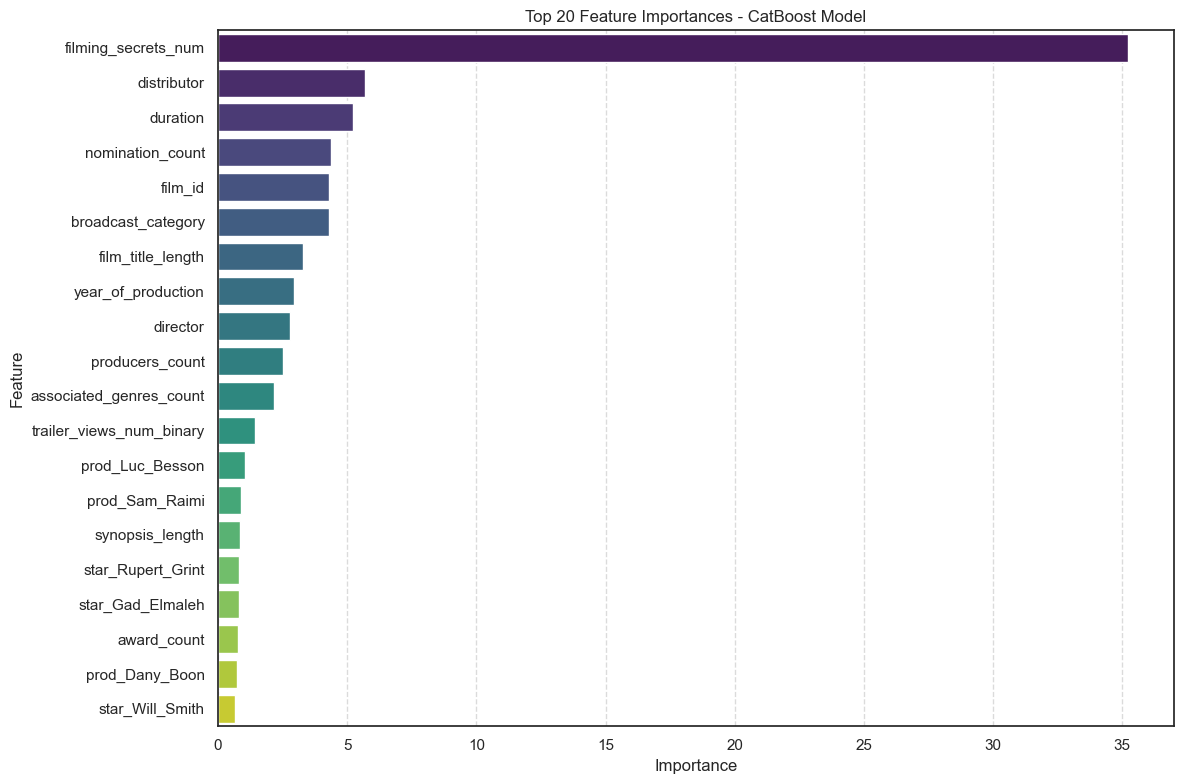

In [69]:
# Top 20 features and their importances from CatBoost model
feature_importances_cat_all = cat_model_all.get_feature_importance(prettified=True)
top_20_cat_all = feature_importances_cat_all.sort_values(by='Importances', ascending=False).head(20)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importances', y='Feature Id', data=top_20_cat_all, palette='viridis', hue='Feature Id')
plt.title('Top 20 Feature Importances - CatBoost Model')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


#### CatBoost Model based on Top 20 Features

In [ ]:
# Top 20 by Feature Importance
X_top_20_cat = df_model_final_cat[['filming_secrets_num',  'distributor', 'duration', 'nomination_count',
                                   'film_id', 'broadcast_category', 'film_title_length', 'year_of_production',
                                   'director', 'producers_count', 'associated_genres_count', 'trailer_views_num_binary',
                                   'prod_Luc Besson', 'prod_Sam Raimi', 'synopsis_length', 'star_Rupert Grint',
                                    'star_Gad Elmaleh', 'award_count', 'prod_Dany Boon', 'star_Will Smith',
                                    'top_stars_count_binary']]

y_top_20_cat = df_model_final_cat["fr_entries"]

X_top_20_cat["stratify_combo"] = X_top_20_cat["top_stars_count_binary"].astype(str) + "_" + X_top_20_cat["trailer_views_num_binary"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_top_20_cat.drop(columns=['stratify_combo', 'top_stars_count_binary'], axis=1), y_top_20_cat, test_size=0.2, random_state=42, stratify=X['stratify_combo'])

# Identify categorical columns (dtype='category' or object)
cat_cols_20 = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

cat_model_top_20 = CatBoostRegressor(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.05,           # Step size for each iteration
    depth=6,                      # Tree depth
    l2_leaf_reg=3,                # L2 regularization
    subsample=0.8,                # Fraction of samples per tree (like bagging)
    rsm=0.9,                      # Random subset of features per tree
    random_strength=5,            # Randomness in scoring splits
    bagging_temperature=0.5,      # Balances between pure bagging and deterministic tree building
    grow_policy='Lossguide',      # More efficient for deeper trees
    od_type='Iter',               # Early stopping by number of iterations without improvement
    od_wait=50,                   # Patience for early stopping
    random_state=42,              # For reproducibility
    verbose=100,                  # Logging interval
)

# Train the model on the training data
cat_model_top_20.fit(X_train, y_train, cat_features=cat_cols_20)

# Make predictions on the test set
y_pred = cat_model_top_20.predict(X_test)

# Calculate MAE (Mean Absolute Error)
mae_cat_top_20 = round(mean_absolute_error(y_test, y_pred), 2)
print(f"MAE = {mae_cat_top_20:.2f}")

# Calculate RMSE (Root Mean Squared Error)
rmse_cat_top_20 = round(root_mean_squared_error(y_test, y_pred),2)
print(f"RMSE: {rmse_cat_top_20:.2f}")

print("Training terminated successfully!")

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_2254/2157587196.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_20_cat["stratify_combo"] = X_top_20_cat["top_stars_count_binary"].astype(str) + "_" + X_top_20_cat["trailer_views_num_binary"].astype(str)


0:	learn: 208659.9999395	total: 18.9ms	remaining: 18.9s
100:	learn: 147005.2950492	total: 735ms	remaining: 6.54s
200:	learn: 137406.5533814	total: 1.34s	remaining: 5.34s
300:	learn: 127101.6844816	total: 1.89s	remaining: 4.4s
400:	learn: 121356.4603486	total: 2.42s	remaining: 3.62s
500:	learn: 114342.2366379	total: 2.98s	remaining: 2.97s
600:	learn: 108904.6175283	total: 3.57s	remaining: 2.37s
700:	learn: 104837.8783854	total: 4.15s	remaining: 1.77s
800:	learn: 100873.2218495	total: 4.7s	remaining: 1.17s
900:	learn: 96749.0363470	total: 5.25s	remaining: 576ms
999:	learn: 92232.2879774	total: 5.79s	remaining: 0us
MAE = 50661.03
RMSE: 138388.26
Training terminated successfully!


#### CatBoost Model based on Top 10 Features

In [74]:
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

X_top_10_cat = df_model_final_cat[['filming_secrets_num',  'distributor', 'duration', 'nomination_count',
                                   'film_id', 'broadcast_category', 'film_title_length', 'year_of_production',
                                   'director', 'producers_count', 'trailer_views_num_binary',
                                    'top_stars_count_binary']]

y_top_10_cat = df_model_final_cat["fr_entries"]

X_top_10_cat["stratify_combo"] = X_top_10_cat["top_stars_count_binary"].astype(str) + "_" + X_top_10_cat["trailer_views_num_binary"].astype(str)

X_train, X_test, y_train, y_test = train_test_split(X_top_10_cat.drop(columns=['stratify_combo', 'top_stars_count_binary', 'trailer_views_num_binary'], axis=1), y_top_10_cat, test_size=0.2, random_state=42, stratify=X['stratify_combo'])

# Identify categorical columns (dtype='category' or object)
cat_cols = X_train.select_dtypes(include=['category', 'object']).columns.tolist()

# Clean feature names to remove unsupported characters
X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# Remove duplicate columns from the feature set
X_train = X_train.loc[:, ~X_train.columns.duplicated()]
X_test = X_test.loc[:, ~X_test.columns.duplicated()]

cat_model_top_10 = CatBoostRegressor(
    iterations=1000,              # Number of boosting iterations
    learning_rate=0.05,           # Step size for each iteration
    depth=6,                      # Tree depth
    l2_leaf_reg=3,                # L2 regularization
    subsample=0.8,                # Fraction of samples per tree (like bagging)
    rsm=0.9,                      # Random subset of features per tree
    random_strength=5,            # Randomness in scoring splits
    bagging_temperature=0.5,      # Balances between pure bagging and deterministic tree building
    grow_policy='Lossguide',      # More efficient for deeper trees
    od_type='Iter',               # Early stopping by number of iterations without improvement
    od_wait=50,                   # Patience for early stopping
    random_state=42,              # For reproducibility
    verbose=100,                  # Logging interval
)

# Train the model on the training data
cat_model_top_10.fit(X_train, y_train, cat_features=cat_cols)

# Make predictions on the test set
y_pred = cat_model_top_10.predict(X_test)

# Calculate MAE (Mean Absolute Error)
mae_cat_top_10 = round(mean_absolute_error(y_test, y_pred), 2)
print(f"MAE = {mae_cat_top_10:.2f}")

# Calculate RMSE (Root Mean Squared Error)
rmse_cat_top_10 = round(root_mean_squared_error(y_test, y_pred),2)
print(f"RMSE: {rmse_cat_top_10:.2f}")

print("Training terminated successfully!")

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_2254/2826913115.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_top_10_cat["stratify_combo"] = X_top_10_cat["top_stars_count_binary"].astype(str) + "_" + X_top_10_cat["trailer_views_num_binary"].astype(str)


0:	learn: 208873.2596337	total: 11.8ms	remaining: 11.8s
100:	learn: 153596.7875731	total: 689ms	remaining: 6.13s
200:	learn: 147394.9959359	total: 1.29s	remaining: 5.13s
300:	learn: 134902.8277704	total: 1.87s	remaining: 4.35s
400:	learn: 128718.1171664	total: 2.37s	remaining: 3.54s
500:	learn: 122635.9160010	total: 2.88s	remaining: 2.87s
600:	learn: 118701.5408336	total: 3.36s	remaining: 2.23s
700:	learn: 115449.6510351	total: 3.84s	remaining: 1.64s
800:	learn: 113129.6248746	total: 4.34s	remaining: 1.08s
900:	learn: 110025.0158288	total: 4.82s	remaining: 530ms
999:	learn: 107354.4663759	total: 5.3s	remaining: 0us
MAE = 52914.55
RMSE: 143949.29
Training terminated successfully!


#### Train and test Ensemble Model

In [89]:
df_model_final_ens = df_model_final.copy()

In [90]:
ensemble_cols = ['year_of_production',
    'release_date_france_year', 'release_date_france_month', 'release_date_france_day',
    'release_season', 'broadcast_category', 'duration_classified',
    'synopsis_length_categorized', 'synopisis_sentiment_categorized',
    'director', 'distributor',
]

# Convert ensemble columns to string if not already
df_model_final_ens[ensemble_cols] = df_model_final_ens[ensemble_cols].apply(lambda x: x.astype(str))

# Get dummy variables
df_dummies_ens = pd.get_dummies(df_model_final_ens[ensemble_cols], drop_first=True).astype('int')

# Concatenate the dummy DataFrame back to the original DataFrame
df_model_final_ens = pd.concat([df_model_final_ens, df_dummies_ens], axis=1)

# Drop the original ensemble columns
df_model_final_ens.drop(columns=ensemble_cols, inplace=True)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, GradientBoostingRegressor

from sklearn.pipeline import Pipeline

X_all_ensemble = df_model_final_ens.drop(columns=["fr_entries"]).copy()
y_all_ensemble = df_model_final_ens["fr_entries"].copy()


# Stratify combo
X_all_ensemble["stratify_combo"] = (
    X_all_ensemble["top_stars_count_binary"].astype(str) + "_" +
    X_all_ensemble["trailer_views_num_binary"].astype(str)
)

# Split out features/target
X_features = X_all_ensemble.drop(columns=["stratify_combo"])
y_target   = y_all_ensemble

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target,
    test_size=0.2, random_state=42,
    stratify=X_all_ensemble["stratify_combo"]
)

# Clean names & drop duplicates
for df in (X_train, X_test):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
    df.drop(columns=df.columns[df.columns.duplicated()], inplace=True)

# Pipelines for CatBoost & XGBoost
catboost_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3,
        subsample=0.8, rsm=0.9, random_strength=5, bagging_temperature=0.5,
        grow_policy='Lossguide', od_type='Iter', od_wait=50,
        random_state=42, verbose=0
    ))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        n_estimators=1000, max_depth=7, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_pipeline),
        ('xgboost', xgb_pipeline)
    ],
    final_estimator=GradientBoostingRegressor(
        n_estimators=200,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ),
    passthrough=True,
    n_jobs=-1
)
# Fit, predict, evaluate
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

ensemble_mae  = round(mean_absolute_error(y_test, y_pred), 2)
ensemble_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)

print(f"Stacking Model MAE = {ensemble_mae:.2f}")
print(f"Stacking Model RMSE = {ensemble_rmse:.2f}")

Stacking Model MAE = 41003.02
Stacking Model RMSE = 130637.24


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from sklearn.pipeline import Pipeline

X_all_ensemble = df_model_final_ens.drop(columns=["fr_entries"]).copy()
y_all_ensemble = df_model_final_ens["fr_entries"].copy()

# Stratify combo
X_all_ensemble["stratify_combo"] = (
    X_all_ensemble["top_stars_count_binary"].astype(str) + "_" +
    X_all_ensemble["trailer_views_num_binary"].astype(str)
)

# Split out features/target
X_features = X_all_ensemble.drop(columns=["stratify_combo"])
y_target   = y_all_ensemble

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_features, y_target,
    test_size=0.2, random_state=42,
    stratify=X_all_ensemble["stratify_combo"]
)

# Clean names & drop duplicates
for df in (X_train, X_test):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
    df.drop(columns=df.columns[df.columns.duplicated()], inplace=True)

# Pipelines for CatBoost & XGBoost
catboost_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3,
        subsample=0.8, rsm=0.9, random_strength=5, bagging_temperature=0.5,
        grow_policy='Lossguide', od_type='Iter', od_wait=50,
        random_state=42, verbose=0
    ))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        n_estimators=1000, max_depth=7, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])

# Stacking ensemble
stacking_model = StackingRegressor(
    estimators=[
        ('catboost', catboost_pipeline),
        ('xgboost', xgb_pipeline)
    ],
    final_estimator=RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42,)
)

# Fit, predict, evaluate
stacking_model.fit(X_train, y_train)
y_pred = stacking_model.predict(X_test)

ensemble_mae  = round(mean_absolute_error(y_test, y_pred), 2)
ensemble_rmse = round(np.sqrt(mean_squared_error(y_test, y_pred)), 2)

print(f"Stacking Model MAE = {ensemble_mae:.2f}")
print(f"Stacking Model RMSE = {ensemble_rmse:.2f}")

Stacking Model MAE = 41081.69
Stacking Model RMSE = 129449.63


#### Ensemble Model based on Top 20 Features in XGBoost and CatBoost Model

In [107]:
df_model_final_ens_ext = df_model_final.copy()

In [109]:
df_model_final_ens_36 = df_model_final_ens_ext[[
    'filming_secrets_num', 'distributor', 'duration', 'nomination_count',
    'film_id', 'broadcast_category', 'film_title_length', 'year_of_production',
    'director', 'producers_count', 'associated_genres_count', 'trailer_views_num_binary',
    'prod_Luc Besson', 'prod_Sam Raimi', 'synopsis_length', 'star_Rupert Grint',
    'star_Gad Elmaleh', 'award_count', 'prod_Dany Boon', 'star_Will Smith',
    'top_stars_count_binary', 'prod_Steve Kloves', 'star_Emma Watson',
    'star_Daniel Radcliffe', 'nomination_categorized', 'prod_Terry Rossio',
    'star_Robert Downey Jr.', 'prod_Chris Morgan', 'star_Christian Clavier',
    'prod_J.J. Abrams', 'star_Keira Knightley', 'star_Gérard Depardieu',
    'prod_Melissa Rosenberg', 'prod_Joe Russo', 'star_Dany Boon', 'nat_Espagne',
    'fr_entries',
]]

ensemble_cols_36 = ['distributor','broadcast_category', 'year_of_production',
                    'director',]

# Convert ensemble columns to string if not already
df_model_final_ens_36[ensemble_cols_36] = df_model_final_ens_36[ensemble_cols_36].apply(lambda x: x.astype(str))

# Get dummy variables
df_dummies_ens_36 = pd.get_dummies(df_model_final_ens_36[ensemble_cols_36], drop_first=True).astype('int')

# Concatenate the dummy DataFrame back to the original DataFrame
df_model_final_ens_36 = pd.concat([df_model_final_ens_36, df_dummies_ens_36], axis=1)

# Drop the original ensemble columns
df_model_final_ens_36.drop(columns=ensemble_cols_36, inplace=True)

/var/folders/ml/v613w2ns1z31hpn87j8vcl8h0000gq/T/ipykernel_2254/4185049794.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model_final_ens_36[ensemble_cols_36] = df_model_final_ens_36[ensemble_cols_36].apply(lambda x: x.astype(str))


In [ ]:
# Define predictors and target
X_36_ensemble = df_model_final_ens_36.drop(columns=["fr_entries"]).copy()
y_36_ensemble = df_model_final_ens_36["fr_entries"].copy()

# Stratify combo
X_36_ensemble["stratify_combo"] = (
    X_36_ensemble["top_stars_count_binary"].astype(str) + "_" +
    X_36_ensemble["trailer_views_num_binary"].astype(str)
)

# Split out features/target
X_36_features = X_36_ensemble.drop(columns=["stratify_combo", "top_stars_count_binary"])
y_36_target   = y_36_ensemble

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_36_features, y_36_target,
    test_size=0.2, random_state=42,
    stratify=X_36_ensemble["stratify_combo"]
)

# Clean names & drop duplicates
for df in (X_train, X_test):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
    df.drop(columns=df.columns[df.columns.duplicated()], inplace=True)

# Pipelines for CatBoost & XGBoost
catboost_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3,
        subsample=0.8, rsm=0.9, random_strength=5, bagging_temperature=0.5,
        grow_policy='Lossguide', od_type='Iter', od_wait=50,
        random_state=42, verbose=0
    ))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        n_estimators=1000, max_depth=7, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])

# Stacking ensemble
stacking_model_36 = StackingRegressor(
    estimators=[
        ('catboost', catboost_pipeline),
        ('xgboost', xgb_pipeline)
    ],
    final_estimator=RandomForestRegressor(
    n_estimators=200,
    max_depth=5,
    random_state=42,)
)

# Fit, predict, evaluate
stacking_model_36.fit(X_train, y_train)
y_pred_36 = stacking_model_36.predict(X_test)

ensemble_mae_36  = round(mean_absolute_error(y_test, y_pred_36), 2)
ensemble_rmse_36 = round(np.sqrt(mean_squared_error(y_test, y_pred_36)), 2)

print(f"Stacking Model MAE 36 = {ensemble_mae_36:.2f}")
print(f"Stacking Model RMSE 36 = {ensemble_rmse_36:.2f}")

Stacking Model MAE = 42314.15
Stacking Model RMSE = 130262.85


#### Ensemble Model based on Top 10 Features in XGBoost and CatBoost Model

In [114]:
df_model_final_ens_20 = df_model_final_ens_ext[[
    'filming_secrets_num', 'distributor', 'duration', 'nomination_count',
    'film_id', 'broadcast_category', 'film_title_length', 'year_of_production',
    'director', 'producers_count', 'trailer_views_num_binary', 'top_stars_count_binary',
    'prod_Steve Kloves', 'star_Emma Watson', 'star_Daniel Radcliffe', 'nomination_categorized',
    'prod_Terry Rossio', 'star_Robert Downey Jr.', 'prod_Chris Morgan', 'prod_Sam Raimi',
    'star_Christian Clavier', 'fr_entries',
]].copy()

ensemble_cols_20 = ['distributor','broadcast_category', 'year_of_production',
                    'director',]

# Convert ensemble columns to string if not already
df_model_final_ens_20[ensemble_cols_20] = df_model_final_ens_20[ensemble_cols_20].apply(lambda x: x.astype(str))

# Get dummy variables
df_dummies_ens_20 = pd.get_dummies(df_model_final_ens_20[ensemble_cols_20], drop_first=True).astype('int')

# Concatenate the dummy DataFrame back to the original DataFrame
df_model_final_ens_20 = pd.concat([df_model_final_ens_20, df_dummies_ens_20], axis=1)

# Drop the original ensemble columns
df_model_final_ens_20.drop(columns=ensemble_cols_20, inplace=True)

In [ ]:
# Define predictors and target
X_20_ensemble = df_model_final_ens_20.drop(columns=["fr_entries"]).copy()
y_20_ensemble = df_model_final_ens_20["fr_entries"].copy()

# Stratify combo
X_20_ensemble["stratify_combo"] = (
    X_20_ensemble["top_stars_count_binary"].astype(str) + "_" +
    X_20_ensemble["trailer_views_num_binary"].astype(str)
)

# Split out features/target
X_20_features = X_20_ensemble.drop(columns=["stratify_combo", "top_stars_count_binary"])
y_20_target   = y_20_ensemble

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_20_features, y_20_target,
    test_size=0.2, random_state=42,
    stratify=X_20_ensemble["stratify_combo"]
)

# Clean names & drop duplicates
for df in (X_train, X_test):
    df.columns = df.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
    df.drop(columns=df.columns[df.columns.duplicated()], inplace=True)

# Pipelines for CatBoost & XGBoost
catboost_pipeline = Pipeline([
    ('model', CatBoostRegressor(
        iterations=1000, learning_rate=0.05, depth=6, l2_leaf_reg=3,
        subsample=0.8, rsm=0.9, random_strength=5, bagging_temperature=0.5,
        grow_policy='Lossguide', od_type='Iter', od_wait=50,
        random_state=42, verbose=0
    ))
])

xgb_pipeline = Pipeline([
    ('model', XGBRegressor(
        n_estimators=1000, max_depth=7, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42
    ))
])

# Stacking ensemble
stacking_model_20 = StackingRegressor(
    estimators=[
        ('catboost', catboost_pipeline),
        ('xgboost', xgb_pipeline)
    ],
    final_estimator=RandomForestRegressor(
    n_estimators=200,
    max_depth=7,
    random_state=42,)
)

# Fit, predict, evaluate
stacking_model_20.fit(X_train, y_train)
y_pred_20 = stacking_model_20.predict(X_test)

ensemble_mae_20  = round(mean_absolute_error(y_test, y_pred_20), 2)
ensemble_rmse_20 = round(np.sqrt(mean_squared_error(y_test, y_pred_20)), 2)

print(f"Stacking Model MAE 20 = {ensemble_mae_20:.2f}")
print(f"Stacking Model RMSE 20 = {ensemble_rmse_20:.2f}")

Stacking Model MAE 36 = 42527.88
Stacking Model RMSE 36 = 129615.39


In [134]:
import pandas as pd
import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import StackingRegressor, RandomForestRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error

# 1) Transformer to preserve DataFrame columns
class DataFramePreserver(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.columns_ = X.columns
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.columns_)

# 2) Build df_model_final_ens_20 (raw, with categorical cols intact)
df_model_final_ens_20 = df_model_final_ens_ext[[
    'filming_secrets_num', 'distributor', 'duration', 'nomination_count',
    'film_id', 'broadcast_category', 'film_title_length', 'year_of_production',
    'director', 'producers_count', 'trailer_views_num_binary',
    'top_stars_count_binary', 'prod_Steve Kloves', 'star_Emma Watson',
    'star_Daniel Radcliffe', 'nomination_categorized', 'prod_Terry Rossio',
    'star_Robert Downey Jr.', 'prod_Chris Morgan', 'prod_Sam Raimi',
    'star_Christian Clavier', 'fr_entries'
]].copy()

# 3) Ensure categorical columns are string type
ensemble_cols_20 = ['distributor', 'broadcast_category', 'year_of_production', 'director']
df_model_final_ens_20[ensemble_cols_20] = df_model_final_ens_20[ensemble_cols_20].astype(str)

# 4) Separate features and target, create stratify key
X = df_model_final_ens_20.drop(columns=['fr_entries']).copy()
y = df_model_final_ens_20['fr_entries'].copy()
stratify_key = (
    X["top_stars_count_binary"].astype(str) + "_" +
    X["trailer_views_num_binary"].astype(str)
)

# 5) Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=stratify_key
)

# 6) Build ColumnTransformer for the 4 categorical columns
preprocessor = ColumnTransformer([
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), ensemble_cols_20)
], remainder="passthrough")

# 7) Define the stacking ensemble
stack = StackingRegressor(
    estimators=[
        ("catboost", CatBoostRegressor(
            iterations=1000, learning_rate=0.05, depth=6,
            random_state=42, verbose=0
        )),
        ("xgboost", XGBRegressor(
            n_estimators=1000, max_depth=7, learning_rate=0.05,
            subsample=0.8, colsample_bytree=0.8, random_state=42
        )),
    ],
    final_estimator=RandomForestRegressor(
        n_estimators=200, max_depth=7, random_state=42
    ),
    passthrough=False,
    n_jobs=-1
)

# 8) Build full pipeline: preserve DataFrame → preprocess → stack
pipeline = Pipeline([
    ("preserve_df", DataFramePreserver()),
    ("preprocess", preprocessor),
    ("model", stack)
])

# 9) Fit
pipeline.fit(X_train, y_train)

# 10) Predict & evaluate
y_pred = pipeline.predict(X_test)
mae  = mean_absolute_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)

print(f"Test MAE:  {mae:.2f}")
print(f"Test RMSE: {rmse:.2f}")


: 

In [117]:
results = pd.DataFrame({
    "MAE": [
        mae_xgb_all,
        mae_xgb_top_20,
        mae_xgb_top_10,
        mae_cat_all,
        mae_cat_top_20,
        mae_cat_top_10,
        ensemble_mae,
        ensemble_mae_36,
        ensemble_mae_20,
    ],
    "RMSE": [
        rmse_xgb_all,
        rmse_xgb_top_20,
        rmse_xgb_top_10,
        rmse_cat_all,
        rmse_cat_top_20,
        rmse_cat_top_10,
        ensemble_rmse,
        ensemble_rmse_36,
        ensemble_rmse_20,
    ]
}, index=[
    "XGB All", 
    "XGB Top 20", 
    "XGB Top 10", 
    "CatBoost All", 
    "CatBoost Top 20", 
    "CatBoost Top 10",
    "Ensemble",
    "Ensemble_36",
    "Ensemble_20",
])

results

,MAE,RMSE
XGB All,43156.031250,130857.679688
XGB Top 20,46682.777344,147262.734375
XGB Top 10,46682.777344,147262.734375
CatBoost All,46463.760000,121223.820000
CatBoost Top 20,50661.030000,138388.260000
CatBoost Top 10,52914.550000,143949.290000
Ensemble,41081.690000,129449.630000
Ensemble_36,42314.150000,130262.850000
Ensemble_20,42527.880000,129615.390000


#### Apply Grid Search to Best Model (XGBoost)

In [35]:
# from sklearn.model_selection import train_test_split, GridSearchCV

# # Split the data into training and testing sets (80/20 split)
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Clean feature names to remove unsupported characters
# X_train.columns = X_train.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)
# X_test.columns = X_test.columns.str.replace(r'[^a-zA-Z0-9_]', '_', regex=True)

# # Remove duplicate columns from the feature set
# X_train = X_train.loc[:, ~X_train.columns.duplicated()]
# X_test = X_test.loc[:, ~X_test.columns.duplicated()]

# # Define base model
# base_lgb_model = lgb.LGBMRegressor(boosting_type='dart', n_jobs=-1, objective='rmse')

# # Define parameter grid for GridSearch
# param_grid = {
#     'n_estimators': [500, 1200],
#     'learning_rate': [0.05],
#     'subsample': [0.8, 1.0],
#     'colsample_bytree': [0.8, 1.0],
# }

# # Use GridSearchCV
# grid_search = GridSearchCV(
#     estimator=base_lgb_model,
#     param_grid=param_grid,
#     cv=3,
#     scoring='neg_root_mean_squared_error',  # Scoring with RMSE
#     verbose=2,
#     n_jobs=-1
# )

# # Fit Grid Search
# grid_search.fit(X_train, y_train)

# # Best model from grid search
# best_lgb_model = grid_search.best_estimator_

# # Training score
# lgb_train_score = best_lgb_model.score(X_train, y_train)
# print("Training Score:", round(lgb_train_score, 2))

# # Make predictions
# y_pred = best_lgb_model.predict(X_test)

# # Evaluation metrics
# mae = mean_absolute_error(y_test, y_pred)
# mse = mean_squared_error(y_test, y_pred)
# rmse = np.sqrt(mse)
# r2 = r2_score(y_test, y_pred)

# print(f"MAE = {mae:.2f}")
# print(f"MSE: {mse}")
# print(f"RMSE: {rmse}")
# print(f"R2 Score: {r2}")

# # Best parameters
# best_lgb_params = grid_search.best_params_
# best_lgb_params_df = pd.DataFrame([best_lgb_params])
# print("Best Hyperparameters from Grid Search:")
# print(best_lgb_params_df)

# print("Training terminated with Grid Search successfully!")
